# Task
The file contains data of 2 produced parts, which are already spatially matched
- part1: partname=demo with sensor Temp
- part2: partname=demoCT with sensor Density

Each line represents a voxel in space with the corresponding sensor values:
maxX, maxY, maxZ, minX, minY, minZ 
describe the geometry of the voxels

To reduce data the following features are generated per voxel:
- Avg: Average of all sensor values in this cube
- Min: Minimum value of all sensor values in this voxel
- Max: Maximum value of all sensor values in this voxel
- Count: Number of sensor values in this voxel
- Sum: Sum of all sensor values in this voxel
- SumSquared: Squared sum of all sensor values in this voxel

The tags column indicates, which of the sensor features are valid. If no value is given, all sensor features are valid.
tags: “partname=demo” means only sensor features of the first part are available in this voxel, which can be seen on the count feature for the second part.

### Typical use cases from industry
<div style="display:flex;">
    <div style="flex:1;">
        <p>
            Part1 (tags: partname=demo or no tag) is produced via 3d printing. Complex geometries require a support structure, which is later removed again.
            For better understanding, this is a visualization of the component, where yellow indicates roughly the primary structure:
            <br><br>Part1 (temp features) contains sensor data from the production of the component (process data). 
            <br><br>Part2 (density features) contains sensor data from the quality control (quality data).
        </p>
    </div>
    <div style="flex:1;">
        <img src="./image.png" alt="printer" width="500">
    </div>
</div>

### Requirements
- Is there any relationship between the process and the quality data?
- Can you label each voxel and check if it is part of the supporting structure or if it is part of the primary structure?


## Setup

In [40]:
import pandas as pd
import numpy as np
import torch
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn import preprocessing
import re

# Preset matplotlib figure sizes
matplotlib.rcParams['figure.figsize'] = [9, 6]

## Read Data

In [41]:
# Read CSV file and create a DataFrame
df = pd.read_csv('AI_test_cubesize3.csv', delimiter=',')
# check shape and columns names
df.shape

(16049, 19)

In [42]:
df.columns

Index(['maxX', 'maxY', 'maxZ', 'minX', 'minY', 'minZ', 'tags', 'AvgTemp',
       'MinTemp', 'MaxTemp', 'CountTemp', 'SumTemp', 'SumsquaredTemp',
       'AvgDensity', 'MinDensity', 'MaxDensity', 'CountDensity', 'SumDensity',
       'SumsquaredDensity'],
      dtype='object')

In [43]:
df.describe(include='all')

,maxX,maxY,maxZ,minX,minY,minZ,tags,AvgTemp,MinTemp,MaxTemp,CountTemp,SumTemp,SumsquaredTemp,AvgDensity,MinDensity,MaxDensity,CountDensity,SumDensity,SumsquaredDensity
count,16049.000000,16049.000000,16049.000000,16049.000000,16049.000000,16049.000000,10005,16049.000000,1.604900e+04,1.604900e+04,16049.000000,16049.000000,1.604900e+04,16049.000000,1.604900e+04,1.604900e+04,16049.000000,16049.000000,1.604900e+04
unique,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,partname=demo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,9657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.089271,-11.852987,-219.351101,-1.620375,-13.556553,-221.027707,NaN,781.846643,inf,1.273398e+03,83.829211,77787.057996,8.639774e+07,69.022886,inf,8.864440e+01,114.008910,19861.534488,3.735254e+06
std,35.545840,23.543563,30.997463,35.509612,23.477831,30.963318,NaN,287.040183,inf,5.050070e+02,62.393814,75854.240940,1.063372e+08,85.279106,inf,1.093144e+02,188.865941,33023.212626,6.229346e+06
min,-65.203058,-71.561194,-279.028711,-65.587137,-72.477532,-279.779688,NaN,0.000000,4.262877e+01,2.225074e-308,0.000000,0.000000,0.000000e+00,0.000000,3.000000e+00,2.225074e-308,0.000000,0.000000,0.000000e+00
25%,-30.396245,-29.389023,-245.414028,-31.454041,-31.435849,-247.410767,NaN,603.850341,1.225577e+02,1.001776e+03,26.000000,17078.152753,1.223932e+07,0.000000,9.000000e+00,2.225074e-308,0.000000,0.000000,0.000000e+00
50%,-5.616055,-10.732986,-222.357265,-6.290181,-12.580989,-224.375611,NaN,740.254277,2.291297e+02,1.161634e+03,75.000000,55859.680284,4.596960e+07,0.000000,1.797693e+308,2.225074e-308,0.000000,0.000000,0.000000e+00
75%,29.291647,4.188907,-195.047357,27.265381,2.121294,-197.095755,NaN,946.559580,4.156306e+02,1.614565e+03,131.000000,107291.296625,1.028572e+08,173.328185,1.797693e+308,2.240000e+02,174.000000,29916.000000,5.567861e+06


In [44]:
df[df['tags'] == 'partname=demo'].head(2)

,maxX,maxY,maxZ,minX,minY,minZ,tags,AvgTemp,MinTemp,MaxTemp,CountTemp,SumTemp,SumsquaredTemp,AvgDensity,MinDensity,MaxDensity,CountDensity,SumDensity,SumsquaredDensity
0,76.126198,9.078488,-158.662013,75.503577,8.429608,-159.381064,partname=demo,1158.081705,735.346359,1561.278863,15,17371.225577,2.166742e+07,0.0,1.797693e+308,2.225074e-308,0,0,0
1,78.176057,5.759926,-158.729964,77.626201,4.745554,-159.337157,partname=demo,1327.760945,815.275311,1854.351687,17,22571.936057,3.244258e+07,0.0,1.797693e+308,2.225074e-308,0,0,0


In [45]:
df[df['tags'] == 'partname=demoCT'].head(2)

,maxX,maxY,maxZ,minX,minY,minZ,tags,AvgTemp,MinTemp,MaxTemp,CountTemp,SumTemp,SumsquaredTemp,AvgDensity,MinDensity,MaxDensity,CountDensity,SumDensity,SumsquaredDensity
475,50.305144,6.067394,-167.599102,50.033611,4.471827,-167.756052,partname=demoCT,0.0,1.797693e+308,2.225074e-308,0,0.0,0.0,192.166667,173.0,206.0,6,1153,222427
476,50.273419,4.070828,-167.416059,49.841297,2.203226,-167.749527,partname=demoCT,0.0,1.797693e+308,2.225074e-308,0,0.0,0.0,173.785714,15.0,221.0,14,2433,458527


In [46]:
df[df['tags'].isna()].head(2)

,maxX,maxY,maxZ,minX,minY,minZ,tags,AvgTemp,MinTemp,MaxTemp,CountTemp,SumTemp,SumsquaredTemp,AvgDensity,MinDensity,MaxDensity,CountDensity,SumDensity,SumsquaredDensity
323,70.939372,1.959731,-150.905459,69.535174,0.25941,-150.994314,NaN,617.356001,495.559503,735.346359,7,4321.492007,2.713127e+06,214.000000,214.0,214.0,1,214,45796
324,77.440158,10.103740,-159.496913,75.509902,8.39254,-161.428702,NaN,1120.235005,602.131439,1667.850799,65,72815.275311,8.696227e+07,169.357143,6.0,215.0,42,7113,1328279


<Axes: xlabel='tags', ylabel='count'>

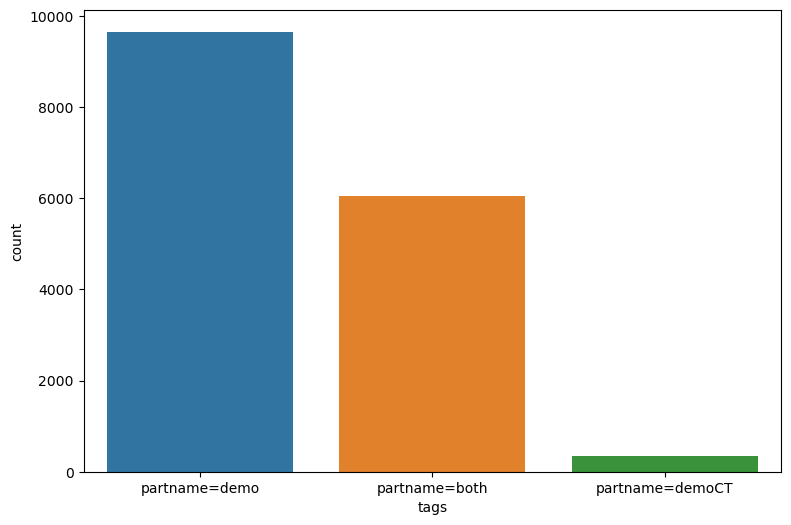

In [47]:
# replace NaN with Unknown label
df['tags'] = df['tags'].fillna('partname=both')

sns.countplot(x = 'tags', data=df)

# Temperature (Process) vs Density (Quality)

The columns related to temperature and density are only used to avoid relying on tags or position for analysis. 

In [48]:
# choose only the columns related to temp and density
pattern = r".*(Temp|Density)$"

temp_density_df = df[[col for col in df.columns if re.match(pattern=pattern, string=col)]]

temp_density_df.columns

Index(['AvgTemp', 'MinTemp', 'MaxTemp', 'CountTemp', 'SumTemp',
       'SumsquaredTemp', 'AvgDensity', 'MinDensity', 'MaxDensity',
       'CountDensity', 'SumDensity', 'SumsquaredDensity'],
      dtype='object')

Text(0.5, 1.0, 'Temperature Density Correlation Matrix')

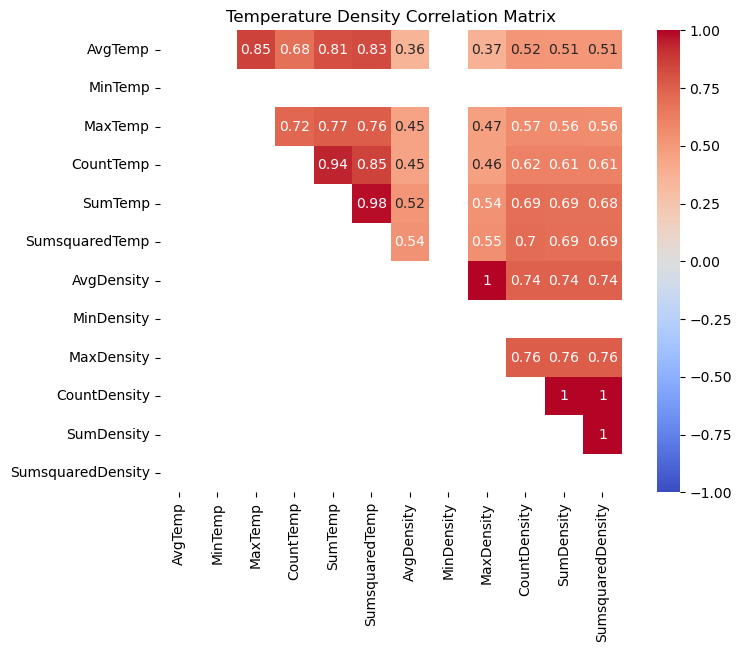

In [49]:
correlation_matrix = temp_density_df.corr()

mask = np.tril(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, square=True)

plt.title('Temperature Density Correlation Matrix')

The correlation matrix shows a relatively strong positive linear relationship between the temp and density.

<Axes: xlabel='AvgDensity', ylabel='AvgTemp'>

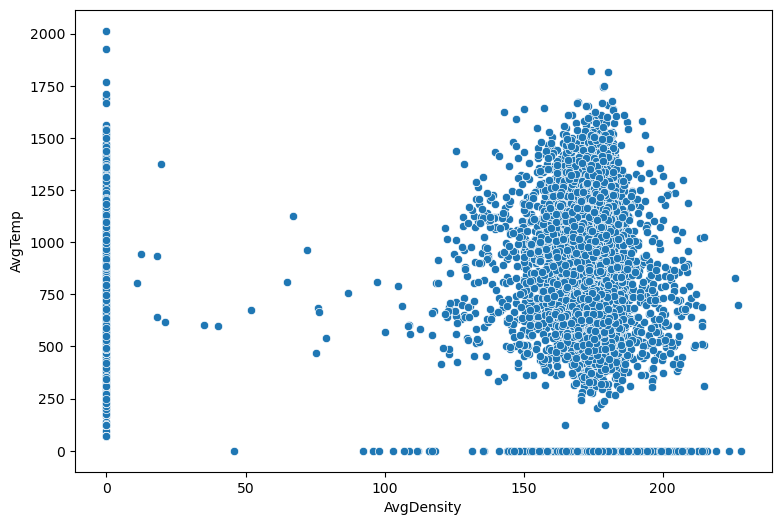

In [51]:
sns.scatterplot(data = temp_density_df, x = 'AvgDensity', y = 'AvgTemp')

Scatter plot confirms the relationship between avg density and avg temp. The two clusters at zero temp and zero density represent the cases when the sensor measurement is not available.

In [ ]:
# TODO student test

# Primary vs. Supporting Structure

## Clustering on Position, Density, Temp
For this part, I will procedd with the hypothesis that only position and density is needed to determine if the voxel is primary or supporting. I will perform unsupervised clustering into two groups primary and support.

In [65]:
pattern = r".*(X|Y|Z|Density|Temp)$"

position_density_df = df[[col for col in df.columns if re.match(pattern=pattern, string=col)]]

train_df = position_density_df.sample(frac=0.8, random_state=42)
test_df = position_density_df.drop(train_df.index)

print(train_df.shape)
print(test_df.shape)

(12839, 18)
(3210, 18)


In [66]:
# normalize the data
X_train_norm = preprocessing.normalize(train_df)

kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto").fit(X_train_norm)

# Get the cluster labels
labels = kmeans.labels_

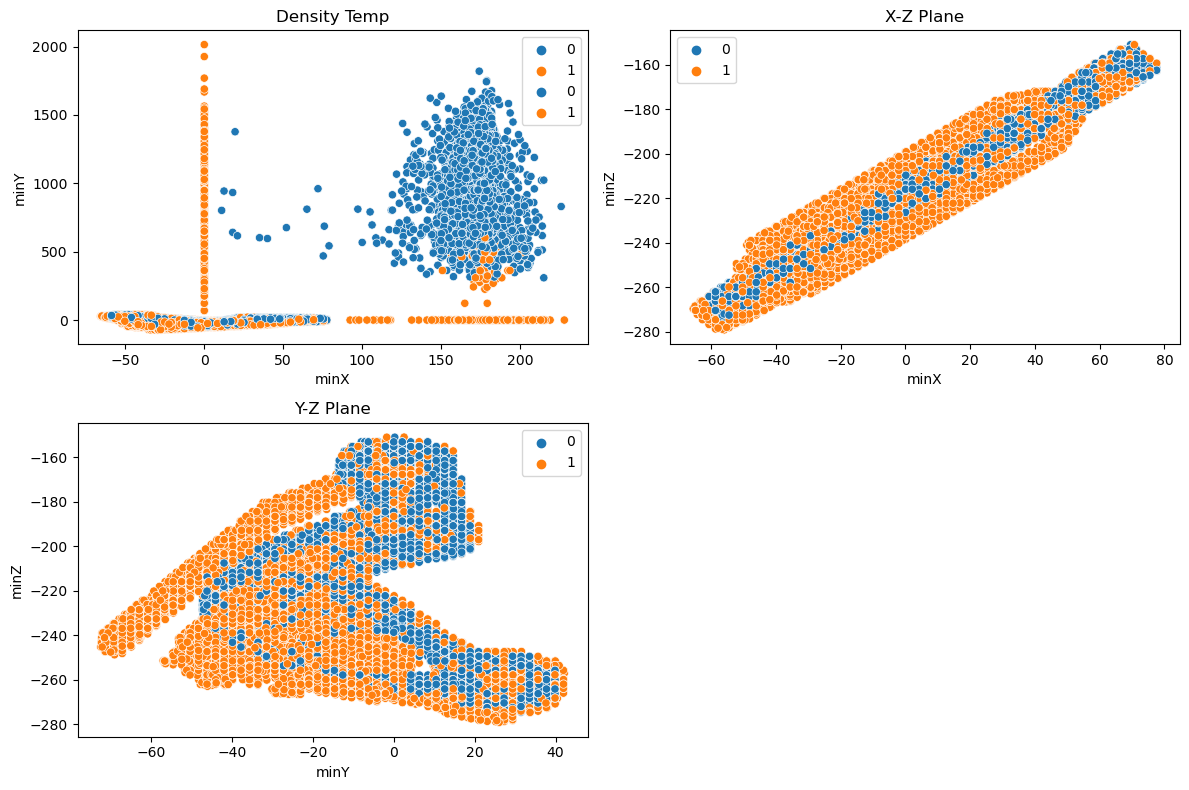

In [67]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Plot 1
plt.subplot(2, 2, 1)
sns.scatterplot(data=train_df, x='minX', y='minY', hue=labels)
plt.title('X-Y Plane')

# Plot 2
plt.subplot(2, 2, 2)
sns.scatterplot(data=train_df, x='minX', y='minZ', hue=labels)
plt.title('X-Z Plane')

# Plot 3
plt.subplot(2, 2, 3)
sns.scatterplot(data=train_df, x='minY', y='minZ', hue=labels)
plt.title('Y-Z Plane')

# Plot 4
plt.subplot(2, 2, 1)
sns.scatterplot(data=train_df, x='AvgDensity', y='AvgTemp', hue=labels)
plt.title('Density Temp')


# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [68]:
import plotly.express as px
fig = px.scatter_3d(data_frame=train_df, x='minX', y='minY', z='minZ', color=labels)

fig.show()

## Clustering on Position

In [54]:
pattern = r".*(X|Y|Z)$"

position_density_df = df[[col for col in df.columns if re.match(pattern=pattern, string=col)]]

train_df = position_density_df.sample(frac=0.8, random_state=42)
test_df = position_density_df.drop(train_df.index)

print(train_df.shape)
print(test_df.shape)

(12839, 6)
(3210, 6)


In [60]:
# normalize the data
X_train_norm = preprocessing.normalize(train_df)

kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto").fit(X_train_norm)

# Get the cluster labels
labels = kmeans.labels_

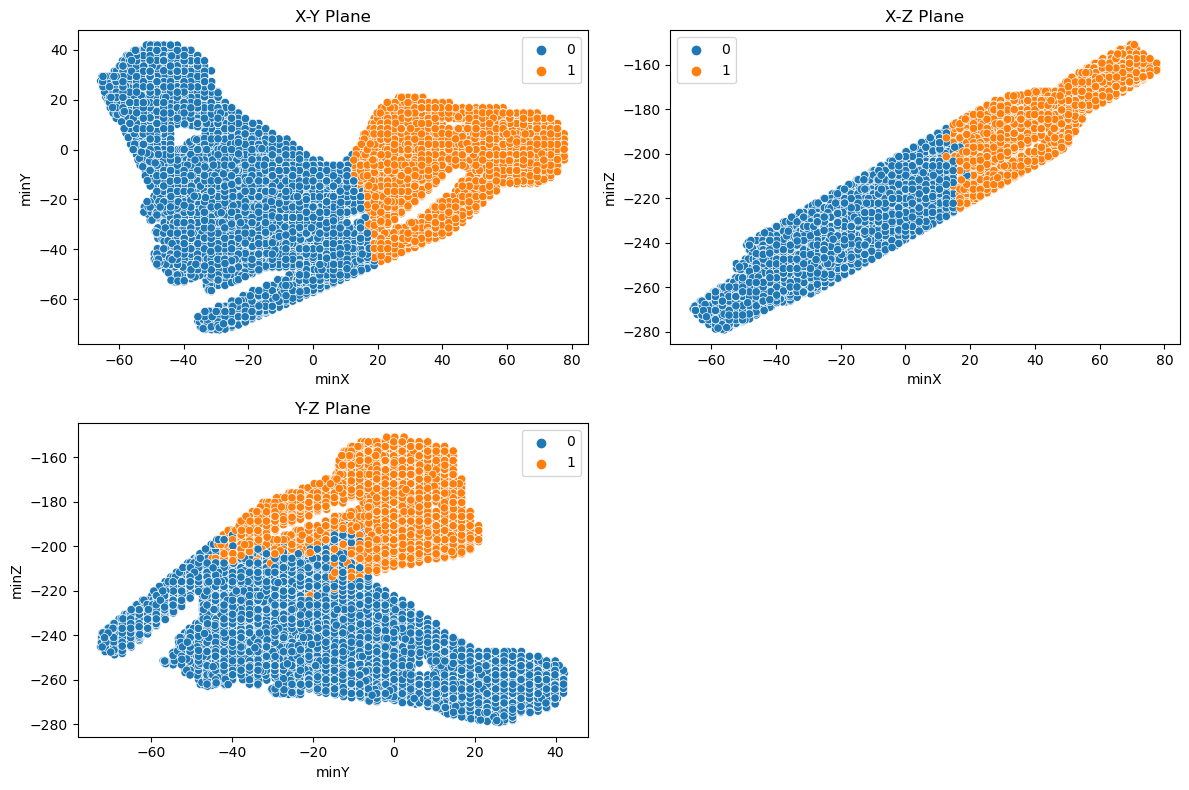

In [62]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Plot 1
plt.subplot(2, 2, 1)
sns.scatterplot(data=train_df, x='minX', y='minY', hue=labels)
plt.title('X-Y Plane')

# Plot 2
plt.subplot(2, 2, 2)
sns.scatterplot(data=train_df, x='minX', y='minZ', hue=labels)
plt.title('X-Z Plane')

# Plot 3
plt.subplot(2, 2, 3)
sns.scatterplot(data=train_df, x='minY', y='minZ', hue=labels)
plt.title('Y-Z Plane')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [63]:
import plotly.express as px
fig = px.scatter_3d(data_frame=train_df, x='minX', y='minY', z='minZ', color=labels)

fig.show()